In [54]:
import array
import random

import numpy as np
import matplotlib.pyplot as plt

from deap import base, benchmarks
from deap import creator
from deap import tools

#from deap import algorithm
#from deap import cma

import customalgorithm as algorithms
import customcma as cma


def runCMAES(objective, init, gen=10, config=[10, 10, 1.0], cmat=np.full((2,2),None)):

    in_mu, in_lambda, in_sigma= config
    
    if (cmat==None).any():
        cmat=np.identity(len(init))
    
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)
    toolbox = base.Toolbox()
    toolbox.register("evaluate", objective)

    strategy = cma.Strategy(centroid=init, sigma=in_sigma, lambda_=in_lambda,mu=in_mu, cmatrix=cmat)

    toolbox.register("generate", strategy.generate, creator.Individual)
    toolbox.register("update", strategy.update)

    stats = tools.Statistics(lambda ind: [ind,ind.fitness.values[0]])
    
    def returnBestIndividual(inds):     
        idx = np.argmin([x[1] for x in inds])
        return inds[idx]
    
    def returnPopulation(inds):     
        return [x[0] for x in inds]
    
    stats.register("returnBest", returnBestIndividual)
    stats.register("returnPop", returnPopulation) 

    upd = algorithms.eaGenerateUpdate(toolbox, ngen=gen, stats=stats, verbose=False)
    popfit = [upd[1][i]['returnBest'] for i in range(len(upd[1]))]
    pops = [upd[1][i]['returnPop'] for i in range(len(upd[1]))]
    #print(upd)
    
    return popfit, pops, upd[-3], upd[-2], upd[-1]

In [61]:
g = 50
dim = 10

s = 600
objective = benchmarks.griewank

init = np.array([0]*(dim-1)+[s])
#init = np.array([s]*dim)


pm = []
pm2 = []
pm3 = []
pm4 = []

for i in range(0,100):
    #init = np.random.uniform(-s, s,dim)
    popmins, pops, covs, sigmas, _ = runCMAES(objective, init, gen=g, config=[10, 10, 1])

    pmins = [p[1] for p in popmins]
    deltas = [pmins[i]-pmins[i+1] for i in range(0,len(pmins)-1)]
    idx = np.argmax(deltas)
    #idx = -1
    #print(idx), print(len(sigmas)), print(centroids[1])
    
    popmins2, _, _, _, _ = runCMAES(objective, init,gen=g, config=[10, 10, sigmas[idx]], cmat =covs[idx])
    popmins3, _, _, _, _ = runCMAES(objective, init,gen=g, config=[10, 10, sigmas[-1]], cmat =covs[-1])    
    popmins4, _, _, _, _ = runCMAES(objective, init,gen=g, config=[10, 10, np.median(sigmas)], cmat =np.median(covs,axis=0))
    
    
    pm.append([p[1] for p in popmins])
    pm2.append([p[1] for p in popmins2])
    pm3.append([p[1] for p in popmins3])
    pm4.append([p[1] for p in popmins4])

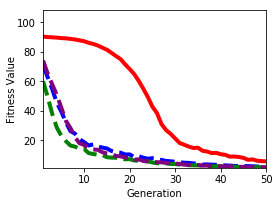

In [62]:

x = np.array(range(1,1+len(popmins)))

#plt.figure(figsize=(6,4.5))
plt.figure(figsize=(4,3))

med1 = np.median(pm,axis=0)
med2 = np.median(pm2,axis=0)
med3 = np.median(pm3,axis=0)
med4 = np.median(pm4,axis=0)

ymin = 0.8*np.min(np.concatenate([med1,med2,med3,med4]))
ymax = 1.2*np.max(np.concatenate([med1,med2,med3,med4]))


plt.xlim(1,g)
plt.ylim(ymin,ymax)
plt.xlabel('Generation')
plt.ylabel('Fitness Value', labelpad=0)
plt.gcf().subplots_adjust(bottom=0.15)
#plt.gcf().subplots_adjust(left=.14)
plt.plot(x, med1, 'red',linewidth=4)
plt.plot(x, med2, 'blue', linestyle='dashed',linewidth=4)
plt.plot(x, med3, 'green', linestyle='dashed',linewidth=4)
plt.plot(x, med4, 'purple', linestyle='dashed',linewidth=4)
plt.savefig("g2.pdf")
plt.show()